In [1]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.optim import AdamW
import os, sys
sys.path.append(os.path.abspath('..'))
import json
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils import load_data

In [2]:
class BERT_LSTM(nn.Module):
    def __init__(self, bert_path, hidden_dim, num_layers, dropout, num_classes, bidirectional=False, freeze_bert=False):
        super(BERT_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.bert = AutoModel.from_pretrained(bert_path).to(self.device)
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, num_classes)


        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, tokenized, h=None, c=None):
        batch_size = tokenized['input_ids'].size(0)
        if h is None:
            h, c = self.init_hidden(batch_size)

        outputs = self.bert(**tokenized)
        hidden_outputs, pooled_outputs = outputs[0], outputs[1]
        out, (h, c) = self.lstm(hidden_outputs, (h, c))
        out = self.fc(out)
        return out, (h, c)
        
    def init_hidden(self, batch_size):
        num_l = self.num_layers * 2 if self.bidirectional else self.num_layers
        hidden = torch.zeros(num_l, batch_size, self.hidden_dim).to(self.device)
        cell = torch.zeros(num_l, batch_size, self.hidden_dim).to(self.device)
        return hidden, cell

In [3]:
# PARAMS
bert_path = 'bert-base-cased'
hidden_dim = 128
num_layers = 2
dropout = 0.1
num_classes = 5
bidirectional = True
freeze_bert = True
batch_size = 16
shuffle = True

In [4]:
train_loader = load_data("../data/train_laptops.json", batch_size=batch_size, shuffle=shuffle)
val_loader = load_data("../data/test_laptops.json", batch_size=batch_size, shuffle=shuffle)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

93
26


In [5]:
tokenizer = AutoTokenizer.from_pretrained(bert_path)
model = BERT_LSTM(bert_path, hidden_dim, num_layers, dropout, num_classes, bidirectional, freeze_bert).to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = AdamW(model.parameters(), lr=5e-5)

In [7]:
with torch.no_grad():
    for idx, sample in enumerate(train_loader):
        text = sample['text']
        tokenized = tokenizer(text, padding="max_length", max_length=75, truncation=True, return_tensors="pt").to(device)
        tags = sample['tags']
        output, (_, _) = model(tokenized)
        output = output.permute(0, 2, 1) # Changing to (batch_size, num_classes, seq_len) as expected by cross_entropy
        print(output.shape)
        loss = criterion(output, tags)
        print(loss)
        break

torch.Size([16, 5, 75])
tensor(1.5968, device='cuda:0')


In [8]:
def start_table():
    print("-"*66)
    print(f"|{'EPOCH':^15}|{'BATCH':^15}|{'TRAIN LOSS':^16}|{'EVAL LOSS':^15}|")
    print("-"*66)

In [9]:
def flatten(l):
    if len(l.shape) == 2:
        l = [item for sublist in l for item in sublist]
        return l

    elif len(l.shape) == 3:
        l = l.argmax(axis=-1)
        return flatten(l)

In [30]:
def plot_loss(loss, title, xlabel, ylabel):
    sns.set(style="darkgrid")
    sns.lineplot(x=np.arange(len(loss)), y=loss).set(title=title, xlabel=xlabel, ylabel=ylabel)
    # plt.show();

In [31]:
def mask(pred, tags):
    tags = np.array(tags); pred = np.array(pred)
    assert len(pred) == len(tags)
    mask = tags != -100
    tags = tags[mask]; pred = pred[mask]
    assert len(pred) == len(tags)
    return pred, tags

In [32]:
def compute_metrics(pred, tags):
    pred = flatten(pred); tags = flatten(tags)
    pred, tags = mask(pred, tags)
    accuracy = (pred == tags).mean()
    print(classification_report(tags, pred, target_names=['B', 'I', 'O', 'X']))
    return accuracy

In [33]:
def train_epoch(model, optimizer, criterion, train_loader, val_loader, device, epoch_num, print_every=50):
    total_loss = 0
    batch_losses = []
    eval_losses = []

    for idx, sample in enumerate(train_loader):
        model.train()

        text = sample['text']
        tokenized = tokenizer(text, padding="max_length", max_length=75, truncation=True, return_tensors="pt").to(device)
        tags = sample['tags']

        optimizer.zero_grad()
        output, (_, _) = model(tokenized)
        output = output.permute(0, 2, 1) # Changing to (batch_size, num_classes, seq_len) as expected by cross_entropy
        loss = criterion(output, tags)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_losses.append(loss.item())

        if (idx+1) % print_every == 0:
            # print(f"EPOCH: {epoch_num} BATCH:{idx+1}/{len(train_loader)} LOSS: {loss.item()}")
            eval_loss = evaluate(model, criterion, val_loader, device)
            eval_losses.append(eval_loss)
            print(f"|{epoch_num:^15}|{idx+1:^15}|{loss.item():^16.4f}|{eval_loss:^15.4f}|")
    
#             plot_loss(batch_losses)

    epoch_loss =  total_loss / len(train_loader)
    print("-"*66 + "\n")
    return model, epoch_loss, batch_losses, eval_losses

In [34]:
def evaluate(model, criterion, test_loader, device):
    model.eval()

    total_loss = 0

    with torch.no_grad():
        for idx, sample in enumerate(test_loader):
            text = sample['text']
            tokenized = tokenizer(text, padding="max_length", max_length=75, truncation=True, return_tensors="pt").to(device)
            tags = sample['tags']

            output, (_, _) = model(tokenized)
            output = output.permute(0, 2, 1) # Changing to (batch_size, num_classes, seq_len) as expected by cross_entropy
            loss = criterion(output, tags)

            total_loss += loss.item()

    epoch_loss =  total_loss / len(test_loader)
    # print(f"\VAL LOSS: {epoch_loss}\n")
    return epoch_loss

In [35]:
def evaluate_complete(model, test_loader, device):
    model.eval()

    outputs = None
    tags = None

    with torch.no_grad():
        for idx, sample in enumerate(test_loader):
            text = sample['text']
            tags_ = sample['tags'].cpu().numpy()

            tokenized = tokenizer(text, padding="max_length", max_length=75, truncation=True, return_tensors="pt").to(device)

            output, (_, _) = model(tokenized)
            output= output.cpu().numpy()

            # Concatenate to the outputs
            outputs = np.concatenate((outputs, output), axis=0) if outputs is not None else output
            tags = np.concatenate((tags, tags_), axis=0) if tags is not None else tags_

    accuracy = compute_metrics(outputs, tags)
    return accuracy

In [63]:
def extract_aspects(tokens, output):
    mapper = {idx: word for idx, word in enumerate(["Q", "B", "I", "O", "X"])}
    predicted = [mapper[pred] for pred in output]
    
    aspects = []
    current = ""
    
    for token, pred_tag in zip(tokens, predicted):
        if pred_tag == "B":
            if current != "":
                aspects.append(current)
            current = token
            
        elif pred_tag == "I":
            current += " " + token
            
        elif pred_tag == "X":
            if token.startswith("##"): current += token[2:]
            else: current += token
                
        else:
            if current != "":
                aspects.append(current)
                current = ""

    if current != "":
        aspects.append(current)
        
    return aspects

In [64]:
def predict_sample(text, model, tokenizer):
    model.eval()
    with torch.no_grad():
        tokenized = tokenizer(text, padding="max_length", max_length=75, truncation=True, return_tensors="pt").to(device)
        output, (_, _) = model(tokenized)
        output = output.argmax(dim=-1).cpu()[0].tolist()
        
        tokens = tokenizer.tokenize(text, add_special_tokens=True, max_length=75, padding='max_length', truncation=True)
        idx = tokens.index("[SEP]")
#         print(idx, tokens, output)
        
        output = output[1:idx]
        tokens = tokens[1:idx]
        
        aspects = extract_aspects(tokens, output)
        return aspects

In [36]:
def train(model, optimizer, criterion, epochs, train_loader, val_loader, device, print_every=50, eval_every=50):
    epoch_losses = []
    batch_losses = []
    eval_losses = []

    for epoch in range(epochs):
        # print(f"[INFO] STARTING EPOCH {epoch+1}:\n")
        start_table()
        model, epoch_loss, batch_losses_, eval_losses = train_epoch(model, optimizer, criterion, train_loader, val_loader, device, epoch+1, print_every)

        epoch_losses.append(epoch_loss)
        batch_losses.extend(batch_losses_)
        eval_losses.extend(eval_losses)

        print(f"EPOCH: {epoch+1} AVG LOSS: {epoch_loss}\n")
        evaluate_complete(model, val_loader, device)

    plt.figure()  
    plot_loss(batch_losses, "Training Loss", "Step", "Loss")
    
    plt.figure()
    plot_loss(epoch_losses, "Training Loss", "Epoch", "Loss")
    
    return model, epoch_losses, batch_losses, eval_losses

In [37]:
epochs = 15
print_every = 20
eval_every = 20

------------------------------------------------------------------
|     EPOCH     |     BATCH     |   TRAIN LOSS   |   EVAL LOSS   |
------------------------------------------------------------------
|       1       |      20       |     0.0984     |    0.2141     |
|       1       |      40       |     0.1425     |    0.2156     |
|       1       |      60       |     0.1983     |    0.2157     |
|       1       |      80       |     0.0667     |    0.2086     |
------------------------------------------------------------------

EPOCH: 1 AVG LOSS: 0.1596856404856969
              precision    recall  f1-score   support

           B       0.81      0.81      0.81       646
           I       0.84      0.61      0.71       466
           O       0.95      0.98      0.97      6101
           X       0.74      0.58      0.65       257

    accuracy                           0.93      7470
   macro avg       0.84      0.74      0.78      7470
weighted avg       0.93      0.93      0.93  

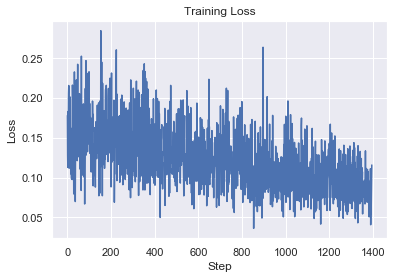

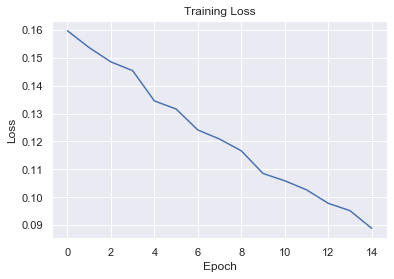

In [38]:
model, epoch_losses, batch_losses, eval_losses = train(model, 
                        optimizer, criterion, epochs, train_loader, val_loader, device, print_every, eval_every)

In [29]:
torch.save(model, "../models/BERT_LSTM_frozen.pt")

In [70]:
text = "My laptop has decent speed but a weak battery!"

In [71]:
predict_sample(text, model, tokenizer)

['speed', 'battery']